Build a baseline model using the weather station data (this approach used all days in 2018 since the data was available).


Then use the model to make predictions for the ENVI-met(micro-climate) data for that specific day and compare it to model predictions using weather station data also for the same day.

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Import

In [83]:
import pandas as pd
import numpy as np
import pathlib
import pickle
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
from datetime import date
import seaborn as sns

# train-test split
from sklearn.model_selection import train_test_split

# 2. Load All Data

In [84]:
# LIMITED DATA
Bldg_Lim = []

# Read all building data and append to list
for path in pathlib.Path("/content/drive/Shareddrives/Microclimate-Building Energy/Data/microclimate_model/Combined/dataset3").iterdir():
        if path.is_file():
            current_file = pd.read_csv(path)
            current_file = current_file.drop(columns=['Unnamed: 0'])
            Bldg_Lim.append(current_file)

# BIG DATA
Bldg_Big = []

# Read all building data and append to list
for path in pathlib.Path("/content/drive/Shareddrives/Microclimate-Building Energy/Data/NN_big_data").iterdir():
        if path.is_file():
            current_file = pd.read_csv(path)
            current_file = current_file.drop(columns=['Unnamed: 0'])
            Bldg_Big.append(current_file)

## 2.1 Preprocessing

1. Adding Month, Hour, and Minute to limited data
2. Removing hours out of ENVI-met accuracy range (after 9 pm) for limited data
3. Add CHWTON/SQFT to columns using condition area for each building taken from
    https://fdm-apps.asu.edu/UFRM/FDS/FacilityData.aspx
4. Drop na rows in limited data (some data points from campus metabolism not available)
5. Drop 'index' column and rename 'rel humid' to 'rel hum' for big data
6. Calculate and create new column for absolute humidity using equations from https://www.hatchability.com/Vaisala.pdf which can be validated using https://planetcalc.com/2167/

In [85]:
## LIMITED DATA ##
# Create Month, Hour, and Minute column for all dataframes in list and drop unnecessary columns
for i in range(len(Bldg_Lim)):
    Bldg_Lim[i].Date_Time = pd.to_datetime(Bldg_Lim[i].Date_Time)
    Bldg_Lim[i]['Month'] = Bldg_Lim[i].Date_Time.dt.month
    Bldg_Lim[i]['Hour'] = Bldg_Lim[i].Date_Time.dt.hour
    Bldg_Lim[i]['Minute'] = Bldg_Lim[i].Date_Time.dt.minute
    Bldg_Lim[i]['Day'] = Bldg_Lim[i].Date_Time.dt.day
    Bldg_Lim[i] = Bldg_Lim[i].drop(columns = ['Date_Time'])

# Remove data after 9pm
for i in range(len(Bldg_Lim)):
    Bldg_Lim[i] = Bldg_Lim[i][(Bldg_Lim[i]['Hour'] <= 20) & (Bldg_Lim[i]['Hour'] > 0)]

# Add Column: CHWTON/Condition Area (SqFt) or ['CHWTON/SQFT']
cond_area = {'Noble Library':88658,'Biodesign B':132215,'Biodesign C':145410,
             'Biodesign A':133016,'Psychology':69864,'Goldwater':165237,'Schwada COB':99857,
             'ISTB 2':41404,'Bulldog Hall':68067,'ISTB 4':231646,'Psychology North':43034}
for i in range(len(Bldg_Lim)):
    if Bldg_Lim[i]['bldgname'][0] in cond_area:
        Bldg_Lim[i]['CHWTON/SQFT'] = Bldg_Lim[i]['CHWTON'] / cond_area[Bldg_Lim[i]['bldgname'][0]]

# Drop NA rows in data
for i in range(len(Bldg_Lim)):
  Bldg_Lim[i] = Bldg_Lim[i].dropna()
  Bldg_Lim[i] = Bldg_Lim[i].reset_index(drop=True)

## BIG DATA ##
# Rename 'Rel Humid' to 'Rel Hum' and 'index' to 'Date_Time' column
for i in range(len(Bldg_Big)):
  Bldg_Big[i] = Bldg_Big[i].rename(columns = {'Rel Humid': 'Rel Hum'})
  Bldg_Big[i] = Bldg_Big[i].rename(columns={'index' : 'Date_Time'})

#Create 'Date' and 'Time' columns
for i in range(len(Bldg_Big)):
  Bldg_Big[i]['Date'] = (Bldg_Big[i]['Date_Time'].str[6:10]+'-'
                         +Bldg_Big[i]['Date_Time'].str[0:2]+'-'
                         +Bldg_Big[i]['Date_Time'].str[3:5])
  Bldg_Big[i]['Time'] = Bldg_Big[i]['Date_Time'].str[11:] 


In [86]:
# Check if NA in data
for i in range(len(Bldg_Lim)):
  null_data = Bldg_Lim[i][Bldg_Lim[i].isnull().any(axis=1)]
  print(null_data)

Empty DataFrame
Columns: [bldgname, Date, Time, Air Temp, Rel Hum, KW, CHWTON, HTmmBTU, Month, Hour, Minute, Day, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Air Temp, Rel Hum, KW, CHWTON, HTmmBTU, Month, Hour, Minute, Day, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Air Temp, Rel Hum, KW, CHWTON, HTmmBTU, Month, Hour, Minute, Day, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Air Temp, Rel Hum, KW, CHWTON, HTmmBTU, Month, Hour, Minute, Day, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Air Temp, Rel Hum, KW, CHWTON, HTmmBTU, Month, Hour, Minute, Day, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Air Temp, Rel Hum, KW, CHWTON, HTmmBTU, Month, Hour, Minute, Day, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Air Temp, Rel Hum, KW, CHWTON, HTmmBTU, Month, Hour, Minute, Day, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date,

In [87]:
# Constants
P_c = 220640
T_c = 647.096
C_1 = -7.85951783
C_2 = 1.84408259
C_3 =  -11.7866497
C_4 = 22.6807411
C_5 = -15.9618719
C_6 = 1.80122502
C = 2.16679

# Convert Rel Hum to Abs Hum for Limited Data
for i in range(len(Bldg_Lim)):
    T_i = Bldg_Lim[i]['Air Temp']
    RH = Bldg_Lim[i]['Rel Hum']/100
    T = T_i + 273.15
    v = 1 - (T/T_c)
    x = (T_c/T)*((C_1*v) + (C_2*np.power(v, 1.5)) + (C_3*np.power(v, 3)) 
                 + (C_4*np.power(v, 3.5)) + (C_5*np.power(v, 4)) + (C_6*np.power(v, 7.5))) 
    P_ws = np.exp(x)*P_c
    P_w = P_ws*RH
    A = C*P_w*100/T
    Bldg_Lim[i]['Abs Hum'] = A

# Convert Rel Hum to Abs Hum for Big Data
for i in range(len(Bldg_Big)):
    T_i = Bldg_Big[i]['Air Temp']
    RH = Bldg_Big[i]['Rel Hum']/100
    T = T_i + 273.15
    v = 1 - (T/T_c)
    x = (T_c/T)*((C_1*v) + (C_2*np.power(v, 1.5)) + (C_3*np.power(v, 3)) 
                 + (C_4*np.power(v, 3.5)) + (C_5*np.power(v, 4)) + (C_6*np.power(v, 7.5))) 
    P_ws = np.exp(x)*P_c
    P_w = P_ws*RH
    A = C*P_w*100/T
    Bldg_Big[i]['Abs Hum'] = A

In [88]:
## Rearrange Columns

# For Limited Data
for i in range(len(Bldg_Lim)):
    cols = ['bldgname','Date','Time','Month','Day','Hour','Minute','Air Temp','Abs Hum', 'Rel Hum','KW','CHWTON','CHWTON/SQFT']
    Bldg_Lim[i] = Bldg_Lim[i][cols]

# For Big Data
for i in range(len(Bldg_Big)):
    cols = ['bldgname','Date','Time','Month','Day','Hour','Minute','Air Temp','Abs Hum', 'Rel Hum','KW','CHWTON','CHWTON/SQFT']
    Bldg_Big[i] = Bldg_Big[i][cols]

# 3. Single Building Analysis - Big Data

## 3.1 Select Building

In [89]:
# Ask user to select building
for i in range(len(Bldg_Big)):
    print(i, Bldg_Big[i]['bldgname'][0])

bldgnum_B = int(input("Enter the number of the building from the list above: "))

Bldg_Big[bldgnum_B]

0 Noble Library
1 Bulldog Hall
2 Psychology
3 Biodesign C
4 ISTB 2
5 ISTB 4
6 Goldwater
7 Schwada COB
8 Biodesign A
9 Biodesign B
10 Psychology North
Enter the number of the building from the list above: 5


,bldgname,Date,Time,Month,Day,Hour,Minute,Air Temp,Abs Hum,Rel Hum,KW,CHWTON,CHWTON/SQFT
0,ISTB 4,2018-01-01,00:00,1,1,0,0,11.0,4.028567,40.24,890.33,70.48,0.000304
1,ISTB 4,2018-01-01,00:15,1,1,0,15,11.0,4.028567,40.24,891.28,59.73,0.000258
2,ISTB 4,2018-01-01,00:30,1,1,0,30,10.0,4.042106,43.01,886.57,64.01,0.000276
3,ISTB 4,2018-01-01,00:45,1,1,0,45,9.0,4.056162,46.00,886.66,63.49,0.000274
4,ISTB 4,2018-01-01,01:00,1,1,1,0,9.0,4.056162,46.00,880.12,68.87,0.000297
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34618,ISTB 4,2018-12-31,22:00,12,31,22,0,6.0,6.773487,93.30,951.10,69.14,0.000298
34619,ISTB 4,2018-12-31,22:15,12,31,22,15,5.0,6.797015,100.00,952.58,70.95,0.000306
34620,ISTB 4,2018-12-31,22:30,12,31,22,30,5.0,6.797015,100.00,937.86,68.62,0.000296
34621,ISTB 4,2018-12-31,22:45,12,31,22,45,6.0,6.773487,93.30,941.16,70.36,0.000304


## 3.2 EDA

### 3.2.1 Boxplots

0 bldgname
1 Date
2 Time
3 Month
4 Day
5 Hour
6 Minute
7 Air Temp
8 Abs Hum
9 Rel Hum
10 KW
11 CHWTON
12 CHWTON/SQFT
Enter the number of the following data columns to graph boxplot: 7

 ISTB 4


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


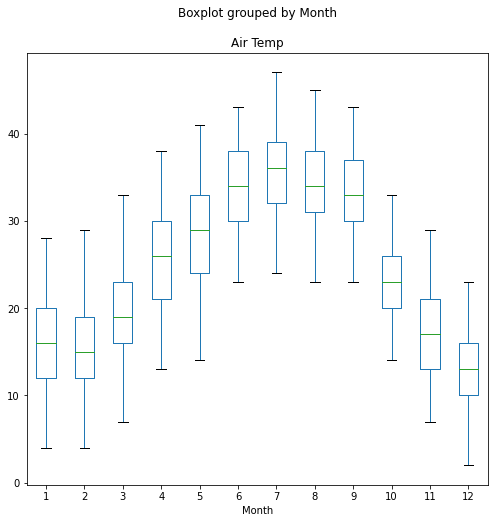

In [90]:
# Show df columns to select for boxplot
x = Bldg_Big[bldgnum_B].columns
for i in range(len(x)):
    print(i, x[i])
# Get column name from user
colname = int(input("Enter the number of the following data columns to graph boxplot: "))
# Plot
print('\n',Bldg_Big[bldgnum_B]['bldgname'][0])
Bldg_Big[bldgnum_B].boxplot(by='Month', column=x[colname], grid = False, figsize = (8,8))

### 3.2.2 Time Series

In [10]:
### will work on create Date and Time column for big data to visualize vs Limited Data

Enter month number: 1

 31 day(s) found in Jan 

0 bldgname
1 Date
2 Time
3 Month
4 Day
5 Hour
6 Minute
7 Air Temp
8 Abs Hum
9 Rel Hum
10 KW
11 CHWTON
12 CHWTON/SQFT
Enter y-axis from column list above: 7


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

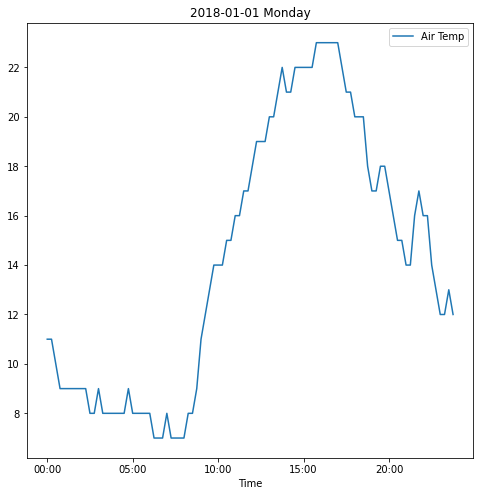

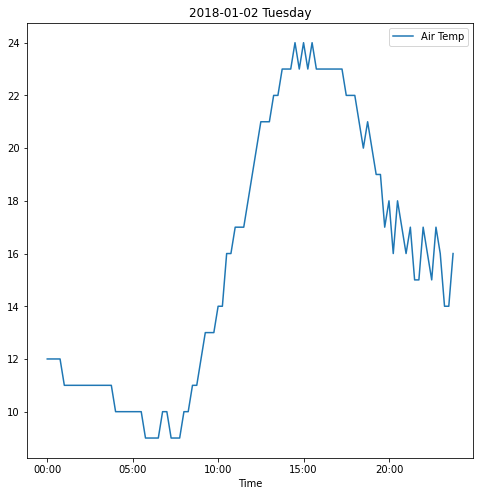

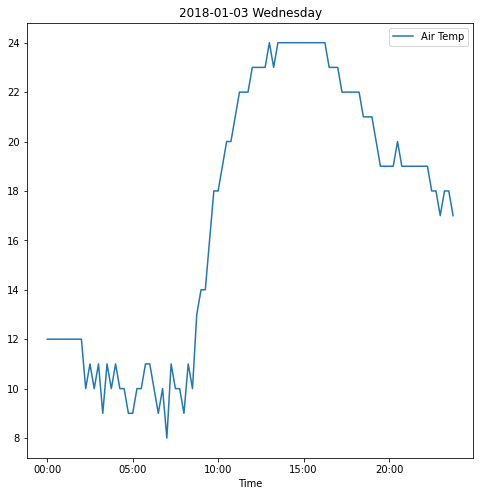

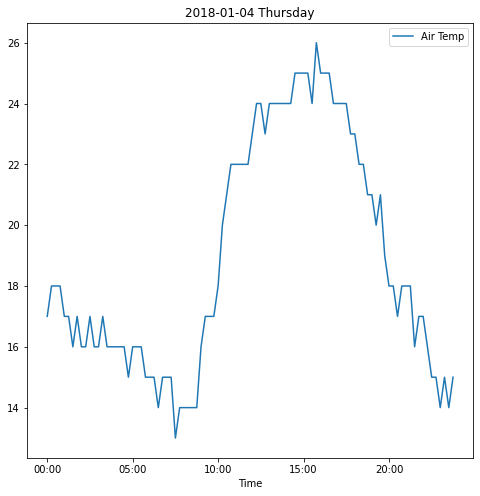

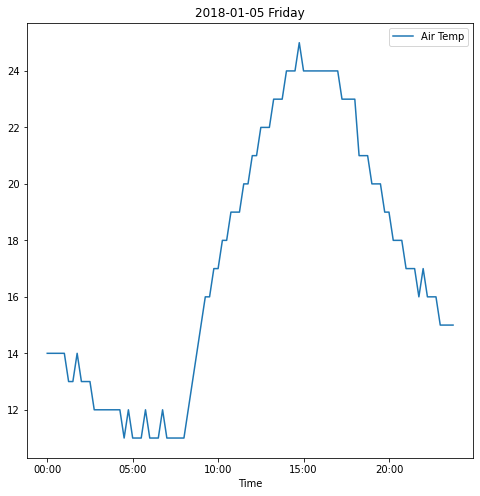

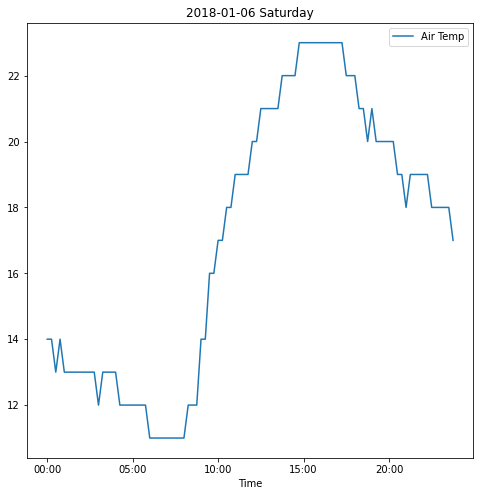

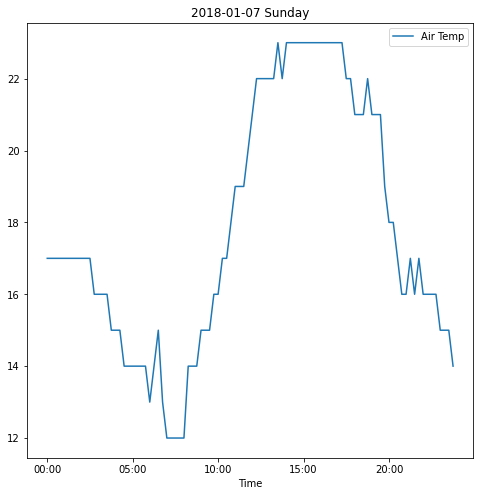

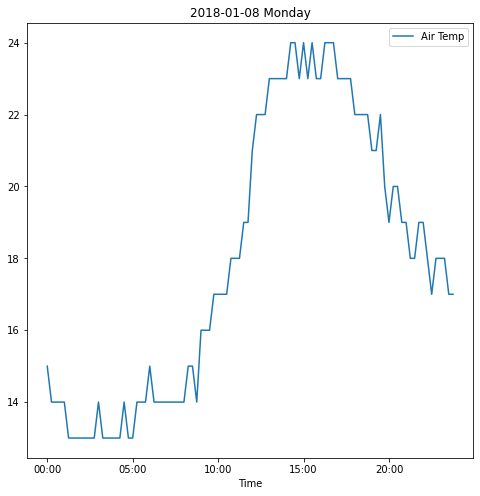

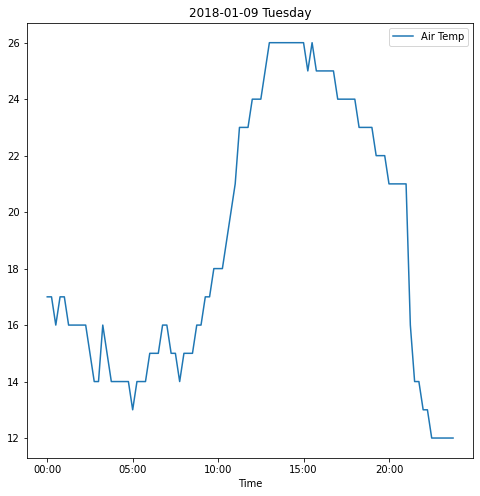

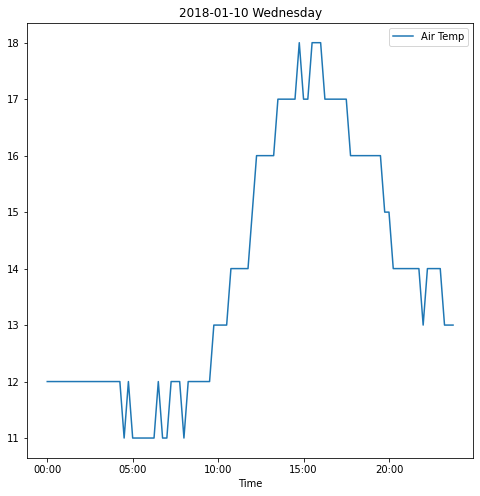

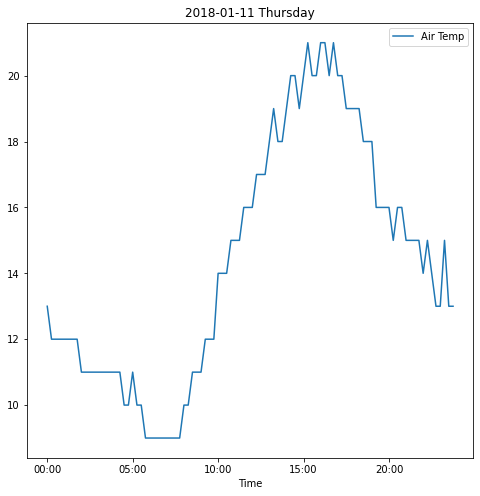

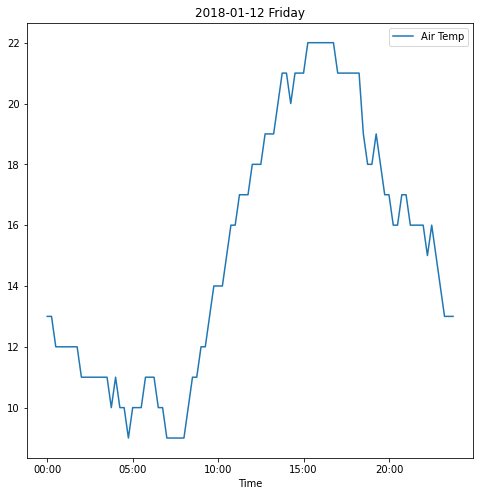

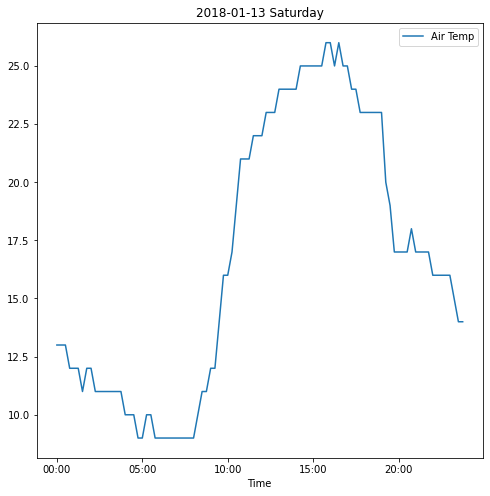

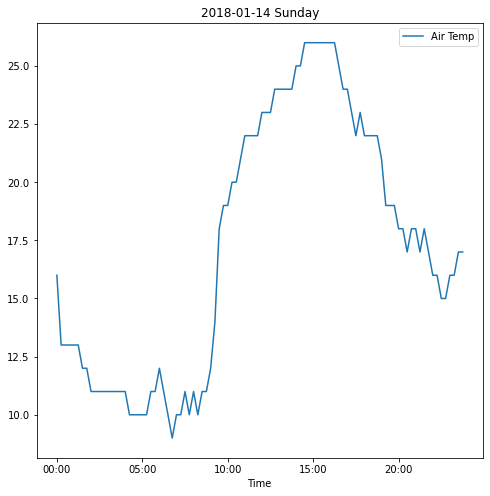

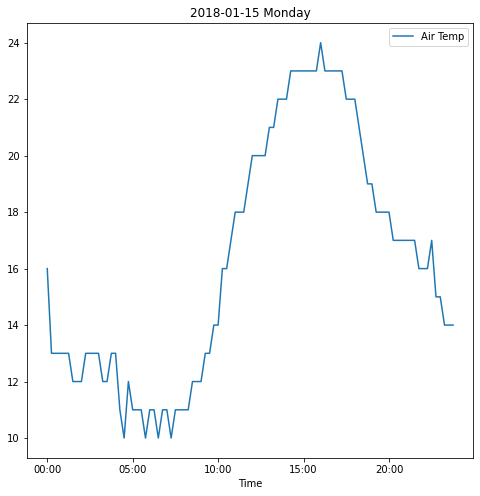

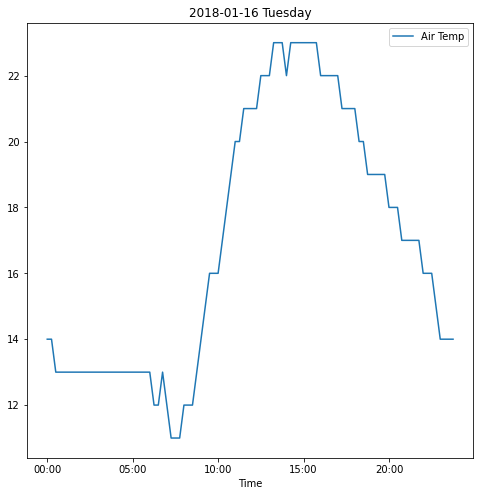

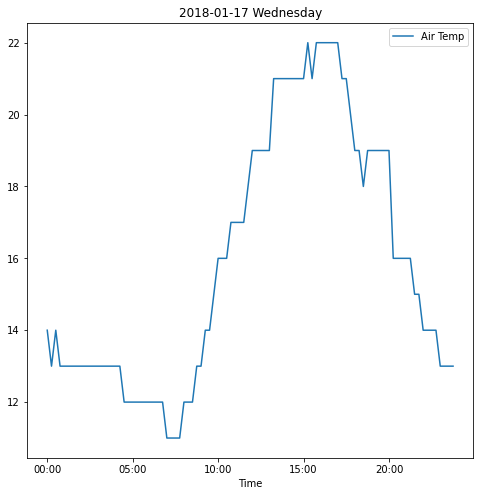

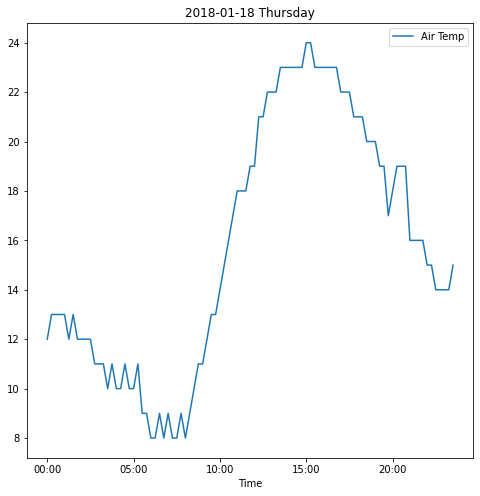

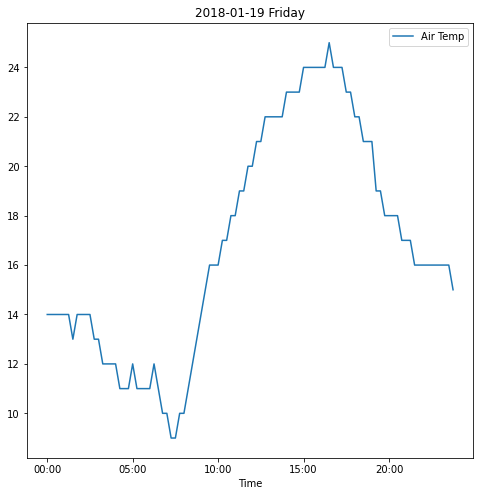

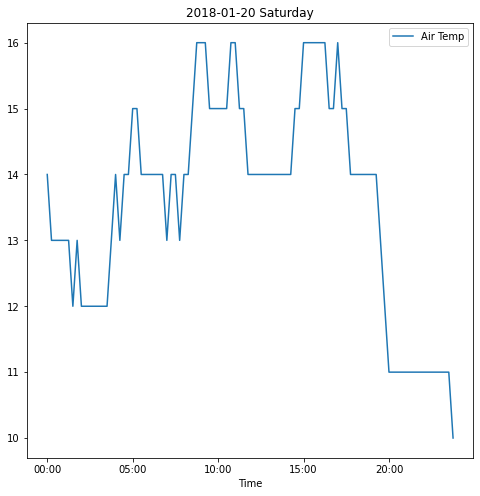

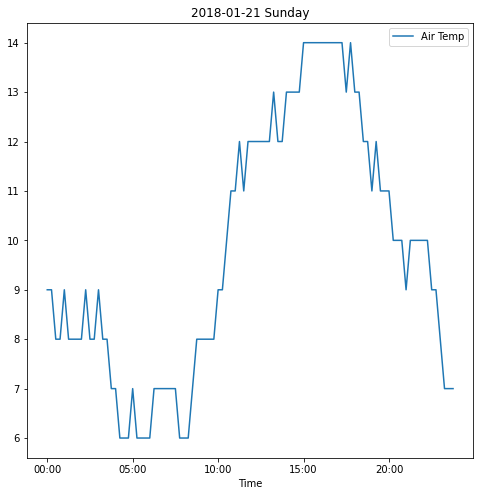

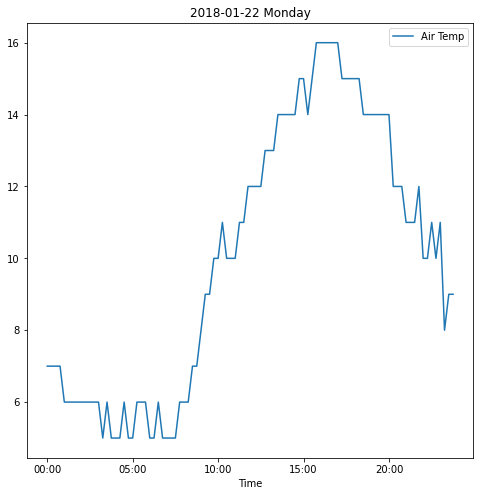

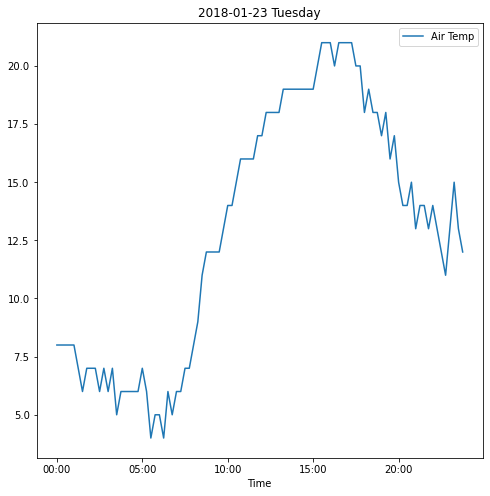

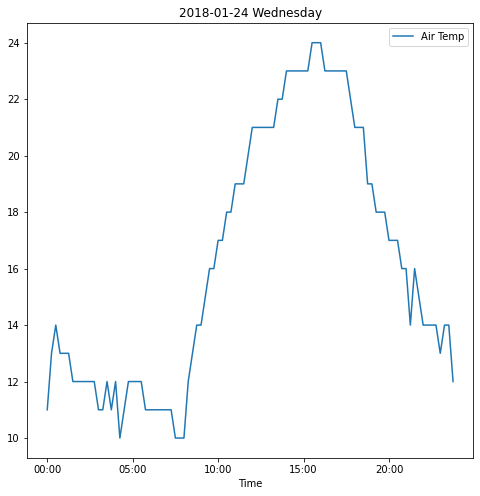

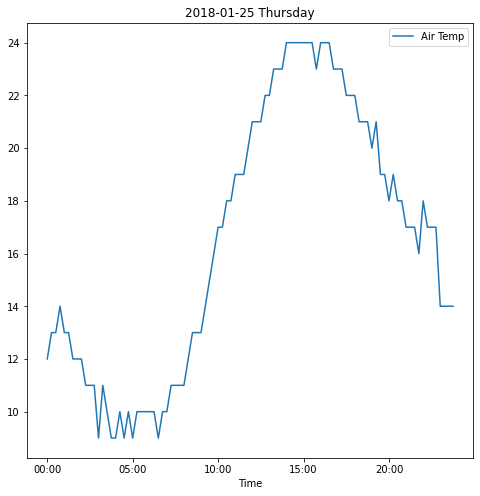

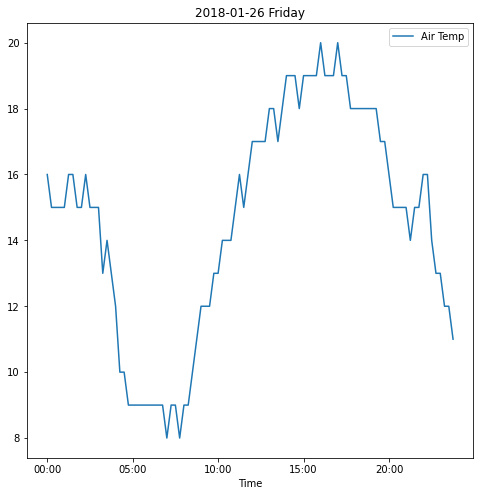

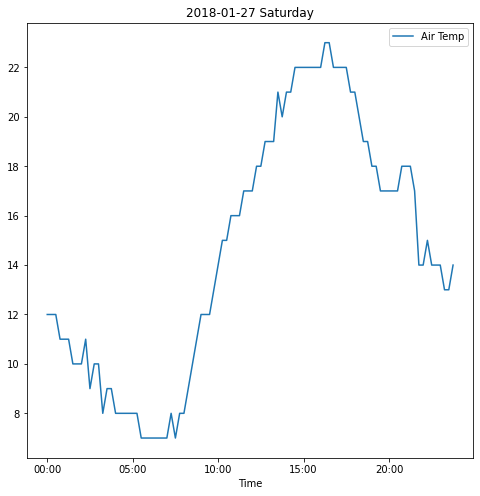

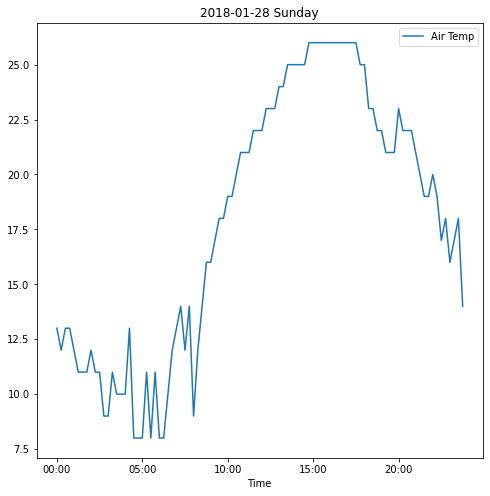

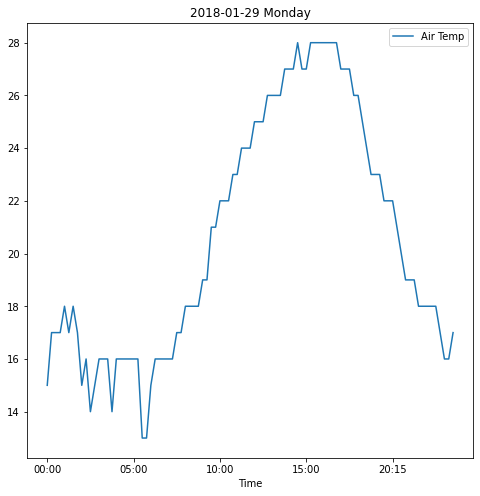

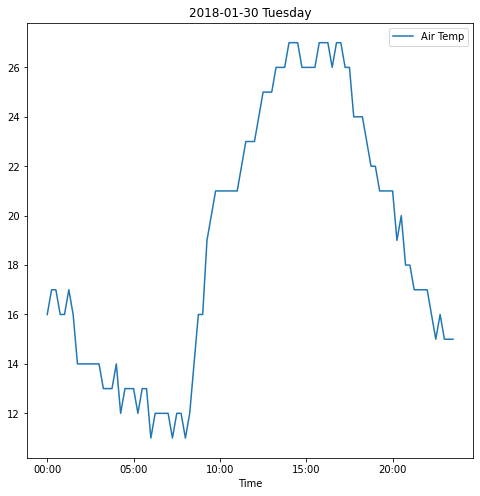

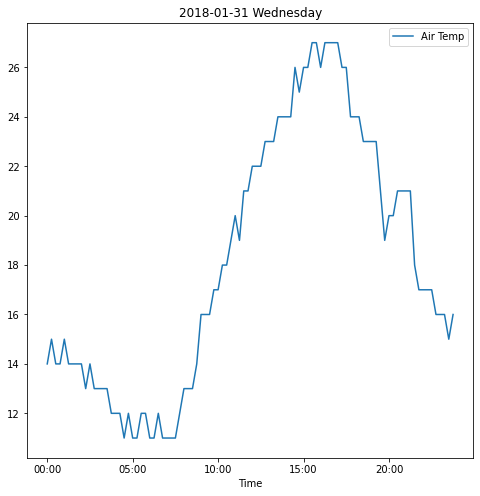

In [91]:
import datetime
# Get month number for plotting
m_num = int(input("Enter month number: "))
# Convert to datetime to get month name
datetime_object = datetime.datetime.strptime(str(m_num), "%m")
m_name = datetime_object.strftime("%b")

# Plot only if entered month is in data
if m_num in Bldg_Big[bldgnum_B]['Month'].unique():
    from datetime import datetime
    # Assign new df for chosen month
    plotdf = pd.DataFrame(Bldg_Big[bldgnum_B][(Bldg_Big[bldgnum_B]['Month'] == m_num)])
    # Show number of days found in chosen month
    x = plotdf['Date'].unique()
    print("\n", len(x), "day(s) found in", m_name, "\n")
    # Show all columns to select y-axis for plotting
    cols = plotdf.columns
    for i in range(len(cols)):
        print(i, cols[i])
    # Get y-axis for plotting
    y_ax = int(input('Enter y-axis from column list above: '))
    y_ax = cols[y_ax]
    x1 = ['']*len(x)
    for i in range(len(x)):
        datetime_object = datetime.strptime(x[i], '%Y-%m-%d')
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        d = days[datetime_object.weekday()]
        plotdf1 = plotdf[(plotdf['Date']==x[i])]
        plotdf1.plot(x = 'Time', y = y_ax, grid = False, figsize = (8,8), title = x[i] + ' ' + d)
else:
    print("Month number not in data")

# 4. Single Building Analysis - Limited Data

## 4.1 Select Building

In [92]:
# Ask user to select building
for i in range(len(Bldg_Lim)):
    print(i, Bldg_Lim[i]['bldgname'][0])

bldgnum_L = int(input("Enter the number of the building from the list above: "))

Bldg_Lim[bldgnum_L].head()

0 Biodesign A
1 Biodesign C
2 Bulldog Hall
3 Biodesign B
4 Goldwater
5 ISTB 4
6 Schwada COB
7 Psychology
8 ISTB 2
9 Noble Library
10 Psychology North
Enter the number of the building from the list above: 5


,bldgname,Date,Time,Month,Day,Hour,Minute,Air Temp,Abs Hum,Rel Hum,KW,CHWTON,CHWTON/SQFT
0,ISTB 4,2018-05-16,05:00,5,16,5,0,25.012220,4.430433,19.218981,902.76,337.88,0.001459
1,ISTB 4,2018-05-16,05:15,5,16,5,15,24.671093,4.864263,21.510339,909.39,343.41,0.001482
2,ISTB 4,2018-05-16,05:30,5,16,5,30,24.495274,4.786310,21.376736,904.81,348.91,0.001506
3,ISTB 4,2018-05-16,05:45,5,16,5,45,24.375078,4.778235,21.486126,893.55,328.88,0.001420
4,ISTB 4,2018-05-16,06:00,5,16,6,0,24.257700,4.793644,21.699019,892.93,329.80,0.001424


## 4.2 EDA

### 4.2.1 Boxplots

0 bldgname
1 Date
2 Time
3 Month
4 Day
5 Hour
6 Minute
7 Air Temp
8 Abs Hum
9 Rel Hum
10 KW
11 CHWTON
12 CHWTON/SQFT
Enter the number of the following data columns to graph boxplot: 7

 ISTB 4


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


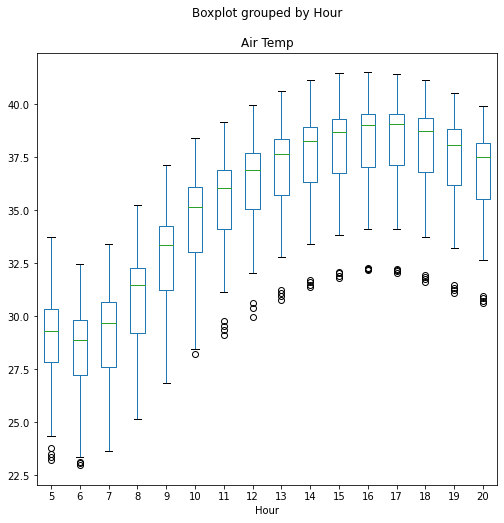

In [93]:
# Show df columns to select for boxplot
x = Bldg_Lim[bldgnum_L].columns
for i in range(len(x)):
    print(i, x[i])
# Get column name from user
colname = int(input("Enter the number of the following data columns to graph boxplot: "))
# Plot
print('\n',Bldg_Lim[bldgnum_L]['bldgname'][0])
Bldg_Lim[bldgnum_L].boxplot(by='Hour', column=x[colname], grid = False, figsize = (8,8))

### 4.2.2 Time Series

Month available:<br>
May: 16, 23 <br>
June: 7, 8, 20, 21, 25<br>
August: 3<br>
September: 11, 29<br>

Enter month number: 6
<class 'str'>

 6 day(s) found in Jun 

0 bldgname
1 Date
2 Time
3 Month
4 Day
5 Hour
6 Minute
7 Air Temp
8 Abs Hum
9 Rel Hum
10 KW
11 CHWTON
12 CHWTON/SQFT
Enter y-axis from column list above: 7


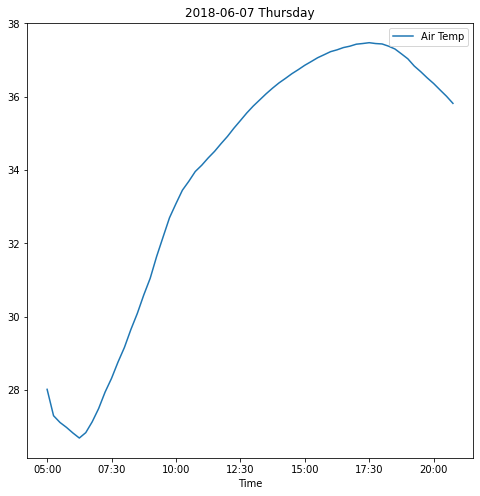

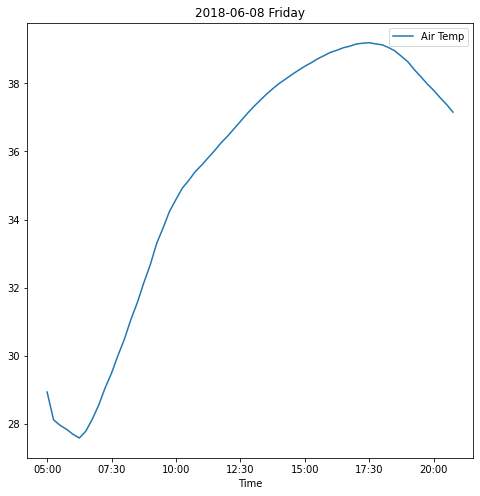

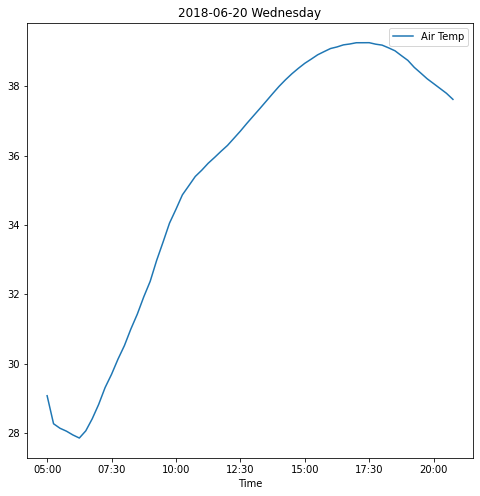

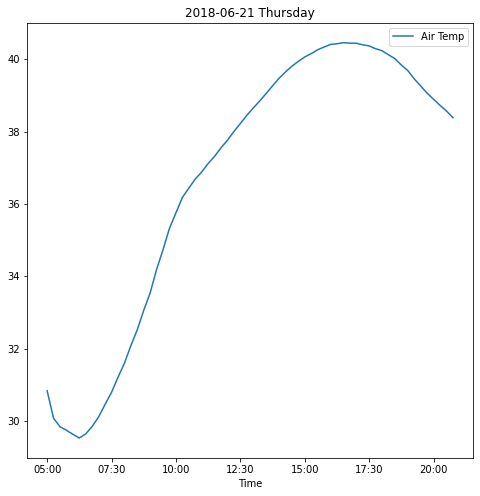

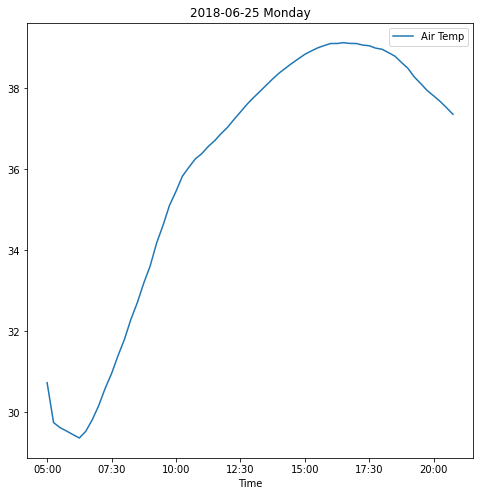

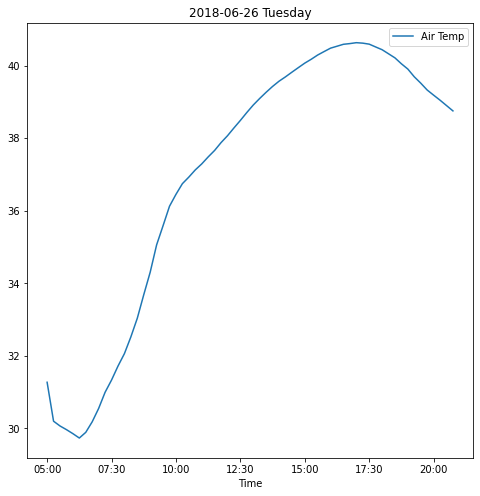

In [94]:
import datetime
# Get month number for plotting
m_num = int(input("Enter month number: "))
# Convert to datetime to get month name
datetime_object = datetime.datetime.strptime(str(m_num), "%m")
m_name = datetime_object.strftime("%b")

# Plot only if entered month is in data
if m_num in Bldg_Lim[bldgnum_L]['Month'].unique():
    from datetime import datetime
    # Assign new df for chosen month
    plotdf = pd.DataFrame(Bldg_Lim[bldgnum_L][(Bldg_Lim[bldgnum_L]['Month'] == m_num)])
    # Show number of days found in chosen month
    x = plotdf['Date'].unique()
    print(type(x[0]))
    print("\n", len(x), "day(s) found in", m_name, "\n")
    # Show all columns to select y-axis for plotting
    cols = plotdf.columns
    for i in range(len(cols)):
        print(i, cols[i])
    # Get y-axis for plotting
    y_ax = int(input('Enter y-axis from column list above: '))
    y_ax = cols[y_ax]
    for i in range(len(x)):
        datetime_object = datetime.strptime(x[i], '%Y-%m-%d')
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        d = days[datetime_object.weekday()]
        plotdf1 = plotdf[(plotdf['Date']==x[i])]
        plotdf1.plot(x = 'Time', y = y_ax, grid = False, figsize = (8,8), title = x[i] + ' ' + d)
else:
    print("Month number not in data")

### 4.2.3 Correlation Matrix

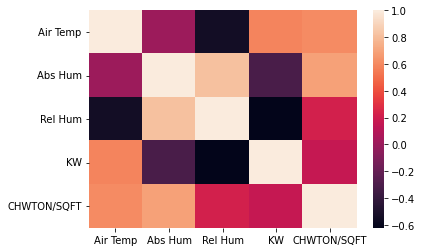

In [95]:
corr_pd = pd.DataFrame(Bldg_Lim[bldgnum_L][['Air Temp','Abs Hum', 'Rel Hum','KW', 'CHWTON/SQFT']])
corrMatrix = corr_pd.corr()
sns.heatmap(corrMatrix)

# 5. Train Models on both datasets 

## 5.1 Define Generalized Model Functions

In [96]:
#using single layer ANN. Model Parameters: hidden layer- 10 neurons, output layer- 1 neuron
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.optimizer_v2.adam import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras import backend as K
def prepare_data(dataset):
    Y = dataset['CHWTON/SQFT']
    X = dataset[['Air Temp', 'Abs Hum']]
    Y= Y.values.reshape(-1, 1)
    # create scaler
    scaler1 = StandardScaler()
    X_scaled = scaler1.fit_transform(X)
    # #do for output variables
    scaler2 = StandardScaler()
    Y_scaled = scaler2.fit_transform(Y)
    X_scaled = np.asarray(X_scaled).astype('float32')
    Y_scaled = np.asarray(Y_scaled).astype('float32')
    return X_scaled,Y_scaled

def huber_loss(y_true, y_pred, clip_delta=1.0):
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta
    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
    return tf.where(cond, squared_loss, linear_loss)

'''
 ' Same as above but returns the mean loss.
'''
def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
    return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

def define_model(activation_type, hidden_layers, loss, kernel_initializer='he_normal', bias_initializer='he_normal'):
    model = Sequential()
    if activation_type == 'leaky_relu':
        model.add(Dense(10, input_dim=2, kernel_initializer='he_normal'))
        model.add(LeakyReLU(alpha=0.1))
        for i in range(0,(hidden_layers-2)):
            model.add(Dense(8))
            model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(16))
        model.add(Dense(1, activation='linear'))
    else:
        model.add(Dense(10, input_dim=2, kernel_initializer='he_normal', bias_initializer='he_normal', activation=activation_type))
        for i in range(0,(hidden_layers-2)):
            model.add(Dense(8, activation=activation_type))
        model.add(Dense(12, activation=activation_type))
        model.add(Dense(1, activation='linear'))
    model.compile(loss= loss, optimizer='adam', metrics = ['mse','mae'])
#     model.summary()
    return model
def fine_tune(model,loss,alpha=0.001):
    model.trainable = True
    fine_tune_at = 2
    for layer in model.layers[:fine_tune_at]:
      layer.trainable =  False
    opt = Adam(learning_rate= alpha)
    model.compile(loss=loss, optimizer=opt, metrics = ['mse','mae'])
    return model
def plot_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
def evaluate(model,X,Y):
    #evaluate on test dataset, add evaluation parameters
    Y_preds = model.predict(X)
    RMSE = np.sqrt(metrics.mean_squared_error(Y, Y_preds))
    R2_score = metrics.r2_score(Y, Y_preds)
#     test_loss = model.evaluate(X, Y)
    return RMSE, R2_score

## 5.2 Prepare Data for feeding into training loop

In [97]:
# Limited Data
X_limited,Y_limited = prepare_data(Bldg_Lim[bldgnum_L])
X_limited_train, X_limited_test, Y_limited_train,Y_limited_test = train_test_split(X_limited,Y_limited , test_size=0.2, random_state=20)
X,Y = prepare_data(Bldg_Big[bldgnum_B])
X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [18]:
# X_limited_test

## 5.3 Hyperparameter Tuning experiments

In [98]:
# eval_func = []
# max_R2 = -inf
# for func in activation_functions:
#     eval_func_layers = []
#     for hl in no_hidden_layers:
#         eval_func_loss = []
#         for loss in loss_functions:
#             model = define_model(func,hl,loss)
#             history = model.fit(X_train, Y_train, batch_size=128, epochs=150,  validation_split=0.2, verbose=0)
#             RMSE, R2 = evaluate(base_model, X_test, Y_test)
#             RMSE_base_model, R2_base_model = evaluate(base_model, X_limited_test,Y_limited_test)
#             eval_func_loss.append(R2)
#         eval_func_layers.append(eval_func_loss)
#     eval_func.append(eval_func_layers)
# print(eval_func)   
# tab = pd.DataFrame(eval_func, activation_functions, no_hidden_layers_headings,loss_functions_headings)
# print(tab)

def tune_multiple_buildings():
    activation_functions = ['relu','elu','selu','leaky_relu','tanh']
    no_hidden_layers = [1,3,5]
    loss_functions = ['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error',huber_loss,huber_loss_mean]
#     loss_functions_headings = ['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error','huber_loss','huber_loss_mean']
    ### Create dataframe and add building names ###
    rf_optimal_model = pd.DataFrame(columns = {"bldgname", "R2_score_bigdata_best","R2_score_limiteddata_best", 'Activation Function','No of hidden layers', 'Loss function' })
    for i in range(len(Bldg_Lim)):
        rf_optimal_model = rf_optimal_model.append({'bldgname': Bldg_Lim[i]['bldgname'].unique()[0]}, ignore_index=True)
    rf_optimal_model.fillna(5)
    ### Train over all hyperparameters over all buildings ###
    for i in range(len(Bldg_Lim)):
        max = 0
        # drop na values if in dataframe
        if (Bldg_Lim[i].isnull().values.any() == True):
            Bldg_Lim[i] = Bldg_Lim[i].dropna()
        building_name = Bldg_Lim[i]['bldgname'][0] 
        print("Find parameters for "+ building_name)
        optimal_hyperparameters=[]
        # Limited Data
        X_limited,Y_limited = prepare_data(Bldg_Lim[i])
        X_limited_train, X_limited_test, Y_limited_train,Y_limited_test = train_test_split(X_limited,Y_limited , test_size=0.1, random_state=20)
        #Big Data
        X,Y = prepare_data(Bldg_Big[i])
        X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
        for func in activation_functions:
            for hl in no_hidden_layers:
                for loss in loss_functions:
                    print("Results for hyperparameters:Activation Fn: "+ func+ " #hidden_layers: "+ str(hl) + " loss function: "+ str(loss))
                    model = define_model(func,hl,loss)
                    history = model.fit(X_train, Y_train, batch_size=128, epochs=150,  validation_split=0.2, verbose=0)
                    RMSE, R2 = evaluate(model, X_test, Y_test)
                    RMSE_base_model, R2_base_model = evaluate(model, X_limited_test,Y_limited_test)
                    print(R2_base_model)
                    if(R2_base_model>max):
                        max = R2_base_model
                        print("Updated hyperparameters for building: "+ building_name +"max_R2:"+str(max)+": Activation Fn: "+ str(func)+ " #hidden_layers: "+ str(hl) + " loss function: "+ str(loss))
                        rf_optimal_model["R2_score_bigdata_best"][i]=R2
                        rf_optimal_model["R2_score_limiteddata_best"][i]=R2_base_model
                        rf_optimal_model["Activation Function"][i]=func
                        rf_optimal_model["No of hidden layers"][i]=hl
                        rf_optimal_model["Loss function"][i]=loss
    rf_optimal_model = rf_optimal_model[["bldgname", "R2_score_bigdata_best","R2_score_limiteddata_best", 'Activation Function','No of hidden layers', 'Loss function']]
    return rf_optimal_model
optimal_model_buildings = tune_multiple_buildings()
display(optimal_model_buildings)


Find parameters for Biodesign A
Results for hyperparameters:Activation Fn: relu #hidden_layers: 1 loss function: mean_squared_error
0.7237004248789713
Updated hyperparameters for building: Biodesign Amax_R2:0.7237004248789713: Activation Fn: relu #hidden_layers: 1 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 1 loss function: mean_absolute_error
0.7480863202547948
Updated hyperparameters for building: Biodesign Amax_R2:0.7480863202547948: Activation Fn: relu #hidden_layers: 1 loss function: mean_absolute_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 1 loss function: mean_absolute_percentage_error
0.6975891124744223
Results for hyperparameters:Activation Fn: relu #hidden_layers: 1 loss function: <function huber_loss at 0x7fd03ca80710>
0.7518273781915978
Updated hyperparameters for building: Biodesign Amax_R2:0.7518273781915978: Activation Fn: relu #hidden_layers: 1 loss function: <function huber_loss at 0x7fd03c

KeyboardInterrupt: ignored

## 5.4 Train Model with Optimized hyperparameters

In [99]:
base_model = define_model('relu',5,'mae')
history = base_model.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=0, validation_split=0.2)

## 5.5 Evaluate Base Model with Big Dataset and Limited Dataset

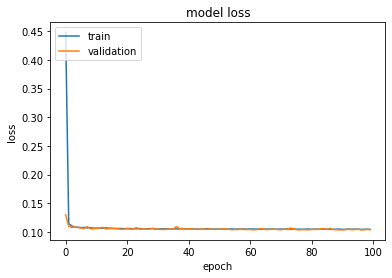

0.9754386718846101
0.9192312803901949


In [100]:
plot_curve(history)
RMSE, R2 = evaluate(base_model, X_test, Y_test)
RMSE_base_model, R2_base_model = evaluate(base_model, X_limited_test,Y_limited_test)
print(R2)
print(R2_base_model)

## 5.6 Transfer features and Fine Tune Base Model on Limited Dataset using various learning rates


In [101]:
l_rates = [0.001,0.00125,0.0015,0.00175,0.002]
R2_max=0
RMSE_min=1
lr=0
for a in l_rates:
  fine_tuned_model = fine_tune(base_model,huber_loss,alpha=a)
  # X_limited,Y_limited = prepare_data(envimet)
  history = fine_tuned_model.fit(X_limited_train,Y_limited_train, epochs=100, verbose=0)
  RMSE_fine_tune ,R2_fine_tune= evaluate(fine_tuned_model,X_limited_test,Y_limited_test)
  if R2_fine_tune>R2_max and RMSE_fine_tune<RMSE_min:
    lr=a
    R2_max=R2_fine_tune
    RMSE_min=RMSE_fine_tune

## 5.7 Evaluate Fine-tuned Model on Limited Dataset

In [102]:
fine_tuned_model = fine_tune(base_model,huber_loss,alpha=lr)
# X_limited,Y_limited = prepare_data(envimet)
history = fine_tuned_model.fit(X_limited_train,Y_limited_train, epochs=100, verbose=0,validation_split=0.1)
RMSE_fine_tune ,R2_fine_tune= evaluate(fine_tuned_model,X_limited_test,Y_limited_test)
print(R2_fine_tune)
print(RMSE_fine_tune)

0.9605741209871541
0.20850378


##5.8 Evaluate and Visualize the difference in the scores with and without using Transfer Learning.

In [103]:
new_model = define_model('relu',5,'mae')
new_history = new_model.fit(X_limited_train, Y_limited_train, batch_size=128, epochs=100, verbose=0, validation_split=0.2)
RMSE_fine_tune_limited ,R2_fine_tune_limited = evaluate(new_model,X_limited_test,Y_limited_test)
print(R2_fine_tune_limited)
print(RMSE_fine_tune_limited)

0.9558844137136875
0.2205562


## 5.9 Visualize the difference in Transfer Learning model and Limited data model.

Loss Curve for Tranfer Learning model:


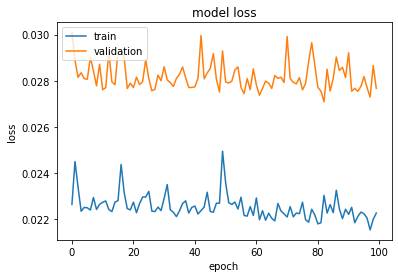

Loss Curve for ANN model using only Limited Data:


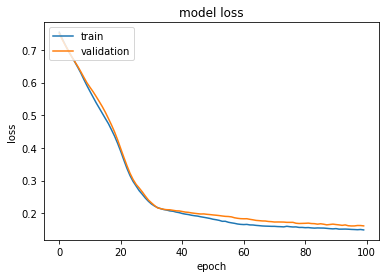

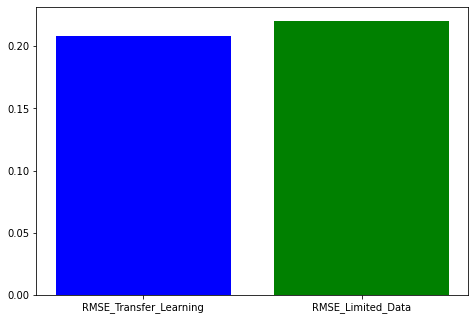

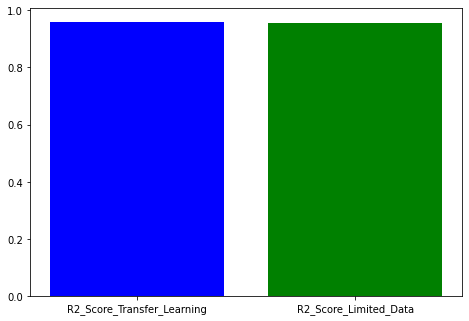

In [104]:
# loss curves for the 2 models
print('Loss Curve for Tranfer Learning model:')
plot_curve(history)
print('Loss Curve for ANN model using only Limited Data:')
plot_curve(new_history)

# difference in RMSE error of the 2 models using Bar Graph
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
error_lables = ['RMSE_Transfer_Learning','RMSE_Limited_Data']
errors = [RMSE_fine_tune,RMSE_fine_tune_limited]
ax.bar(error_lables[0], errors[0], color='b')
ax.bar(error_lables[1], errors[1], color='g')
plt.show()

# difference in R2 scores of the 2 models using Bar Graph
fig1 = plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
score_lables = ['R2_Score_Transfer_Learning','R2_Score_Limited_Data']
scores = [R2_fine_tune,R2_fine_tune_limited]
ax1.bar(score_lables[0], scores[0], color='b')
ax1.bar(score_lables[1], scores[1], color='g')
plt.show()

## 5.10 Implement for all Buildings and report score

In [105]:
from IPython.display import display
def model_multiple():
    ### Create dataframe and add building names ###
    rf_bld_scores = pd.DataFrame(columns = {"bldgname", "R2_score_base_model","RMSE_score_base_model", "R2_score_finetuned_model","RMSE_score_finetuned_model"})
    for i in range(len(Bldg_Lim)):
        rf_bld_scores = rf_bld_scores.append({'bldgname': Bldg_Lim[i]['bldgname'].unique()[0]}, ignore_index=True)
    rf_bld_scores.fillna(5)
    ### Append scores to all buildings ###
    for i in range(len(Bldg_Lim)):
        # drop na values if in dataframe
        if (Bldg_Lim[i].isnull().values.any() == True):
            Bldg_Lim[i] = Bldg_Lim[i].dropna()
        building_name = Bldg_Lim[i]['bldgname'][0] 
        print("Train model for "+ building_name )
        # Limited Data
        X_limited,Y_limited = prepare_data(Bldg_Lim[i])
        X_limited_train, X_limited_test, Y_limited_train,Y_limited_test = train_test_split(X_limited,Y_limited , test_size=0.1, random_state=20)
        #Big Data
        X,Y = prepare_data(Bldg_Big[i])
        X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
        base_model = define_model('relu',3, huber_loss_mean)
        print("Train model for "+ building_name +" Big Data" )
        history_base = base_model.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=0, validation_split=0.2)
        RMSE, R2 = evaluate(base_model, X_test, Y_test)
        RMSE_base_model, R2_base_model = evaluate(base_model, X_limited_test,Y_limited_test)
        rf_bld_scores["R2_score_base_model"][i] = R2_base_model
        rf_bld_scores["RMSE_score_base_model"][i] = RMSE_base_model   
        fine_tuned_model = fine_tune(base_model,huber_loss_mean,alpha=lr)
        print("Train model for "+ building_name +" Limited Data" )
        history_fine_tune = fine_tuned_model.fit(X_limited_train,Y_limited_train, epochs=50, verbose=0)
        RMSE_fine_tune ,R2_fine_tune= evaluate(fine_tuned_model,X_limited_test,Y_limited_test)
        rf_bld_scores["R2_score_finetuned_model"][i] = R2_fine_tune
        rf_bld_scores["RMSE_score_finetuned_model"][i] = RMSE_fine_tune
        rf_bld_scores= rf_bld_scores[["bldgname", "R2_score_base_model","RMSE_score_base_model", "R2_score_finetuned_model","RMSE_score_finetuned_model"]]
    return rf_bld_scores
multiple_bldg_scores = model_multiple()
display(multiple_bldg_scores)

Train model for Biodesign A
Train model for Biodesign A Big Data
Train model for Biodesign A Limited Data
Train model for Biodesign C
Train model for Biodesign C Big Data
Train model for Biodesign C Limited Data
Train model for Bulldog Hall
Train model for Bulldog Hall Big Data
Train model for Bulldog Hall Limited Data
Train model for Biodesign B
Train model for Biodesign B Big Data
Train model for Biodesign B Limited Data
Train model for Goldwater
Train model for Goldwater Big Data
Train model for Goldwater Limited Data
Train model for ISTB 4
Train model for ISTB 4 Big Data
Train model for ISTB 4 Limited Data
Train model for Schwada COB
Train model for Schwada COB Big Data
Train model for Schwada COB Limited Data
Train model for Psychology
Train model for Psychology Big Data
Train model for Psychology Limited Data
Train model for ISTB 2
Train model for ISTB 2 Big Data
Train model for ISTB 2 Limited Data
Train model for Noble Library
Train model for Noble Library Big Data
Train model f

,bldgname,R2_score_base_model,RMSE_score_base_model,R2_score_finetuned_model,RMSE_score_finetuned_model
0,Biodesign A,0.766276,0.486212,0.85235,0.386448
1,Biodesign C,0.194048,0.910358,0.846553,0.397226
2,Bulldog Hall,0.447116,0.76159,0.606667,0.642368
3,Biodesign B,0.344613,0.83934,0.93709,0.260045
4,Goldwater,0.91642,0.300793,0.955631,0.219159
5,ISTB 4,0.905844,0.292041,0.940339,0.232469
6,Schwada COB,0.838555,0.429816,0.89397,0.348324
7,Psychology,0.70734,0.528408,0.877596,0.341732
8,ISTB 2,0.837013,0.417905,0.9156,0.300727
9,Noble Library,0.384611,0.813875,0.719203,0.549767


<!-- Which buildings are we training for? To be decided depending on results  -->
<!-- Train for all buildings automatically and report the scores for base_model and fine_tuned_model. -->
<!-- What scores is RF reporting? RF reports the R2 score. Add R2 score to evaluators. Create a list for evaluating and then visualise it. Not a great score, needs improvements.  -->
<!-- How to visualise the results? Made comparison matrix for now -->
<!-- How to improve the results? Experiment with loss function -->
<!-- Automate model selection: run over iterations of activation function, number of hidden layers, loss function  -->
lr scheduler
Change Y to y everywhere(Regression problem)
Add functionality to pass building names which we want to model